# Hugging Face Model
##### uv add huggingface_hub
##### uv add transformers accelerate
##### uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
##### # uv add -U bitsandbytes (-U : bitsandbytes 최신 버전으로 업데이트)

In [5]:
from dotenv import load_dotenv
load_dotenv()

from huggingface_hub import login
import os

login(token=os.getenv('HUGGINGFACE_API_KEY'))

import torch

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from transformers import AutoTokenizer, BitsAndBytesConfig, Gemma3ForCausalLM
from transformers import pipeline

2.8.0+cu126
cuda


## 멀티 모달 + 복수 input/output 다루기
#### 여러개/다양한 타입을 넣으면 응답이 달라지는 것 확인

In [ ]:
# 파이프라인 만들기
pipe = pipeline(
    "text-generation",
    model="google/gemma-3-1b-it", # 멀티 모달 모델(텍스트 + 이미지)
    device=device,
    torch_dtype=torch.bfloat16
)

# 입력값 만들기
messages_text = [
    {
        "role": "system",
        "content": "친절하게 말하세요"
    },
    {
        "role": "user",
        "content": "오늘 하루를 응원해주세요"
    }
]

messages_type = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "친절하게 말하세요"}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "오늘 하루를 응원해주세요"},
            {"type": "text", "text": "오늘 하루를 응원해주세요"}
        ] 
    }
]

output = pipe(messages_text, max_new_tokens=50)
print(output)

Device set to use cuda


[{'generated_text': [{'role': 'system', 'content': '친절하게 말하세요'}, {'role': 'user', 'content': '오늘 하루를 응원해주세요'}, {'role': 'assistant', 'content': '안녕하세요! 😊 오늘 하루를 응원해 드릴게요.\n\n힘든 하루였는지, 기쁜 하루였는지, 혹은 평범한 하루였는지 궁금하네요. 중요한 건 오늘 하루를 보내는 동안 긍정적인 마음을'}]}]


In [27]:
# 출력값 파싱
for out in output:
    print(out)
    print(out["generated_text"])
    for x in out["generated_text"]:
        print(x)

{'generated_text': [{'role': 'system', 'content': '친절하게 말하세요'}, {'role': 'user', 'content': '오늘 하루를 응원해주세요'}, {'role': 'assistant', 'content': '안녕하세요! 😊 오늘 하루를 응원해 드릴게요.\n\n힘든 하루였는지, 기쁜 하루였는지, 혹은 평범한 하루였는지 궁금하네요. 중요한 건 오늘 하루를 보내는 동안 긍정적인 마음을'}]}
[{'role': 'system', 'content': '친절하게 말하세요'}, {'role': 'user', 'content': '오늘 하루를 응원해주세요'}, {'role': 'assistant', 'content': '안녕하세요! 😊 오늘 하루를 응원해 드릴게요.\n\n힘든 하루였는지, 기쁜 하루였는지, 혹은 평범한 하루였는지 궁금하네요. 중요한 건 오늘 하루를 보내는 동안 긍정적인 마음을'}]
{'role': 'system', 'content': '친절하게 말하세요'}
{'role': 'user', 'content': '오늘 하루를 응원해주세요'}
{'role': 'assistant', 'content': '안녕하세요! 😊 오늘 하루를 응원해 드릴게요.\n\n힘든 하루였는지, 기쁜 하루였는지, 혹은 평범한 하루였는지 궁금하네요. 중요한 건 오늘 하루를 보내는 동안 긍정적인 마음을'}


## LLM 학습을 위한 input/output 형태 이해
#### 사용자 input을 시스템이 이해할 수 있게 변환(토크나이즈)하여 모델에 요청하고
#### 모델의 output을 다시 사용자가 이해할 수 있는 형태로 변환하는 과정을 이해하는 것이 포인트 

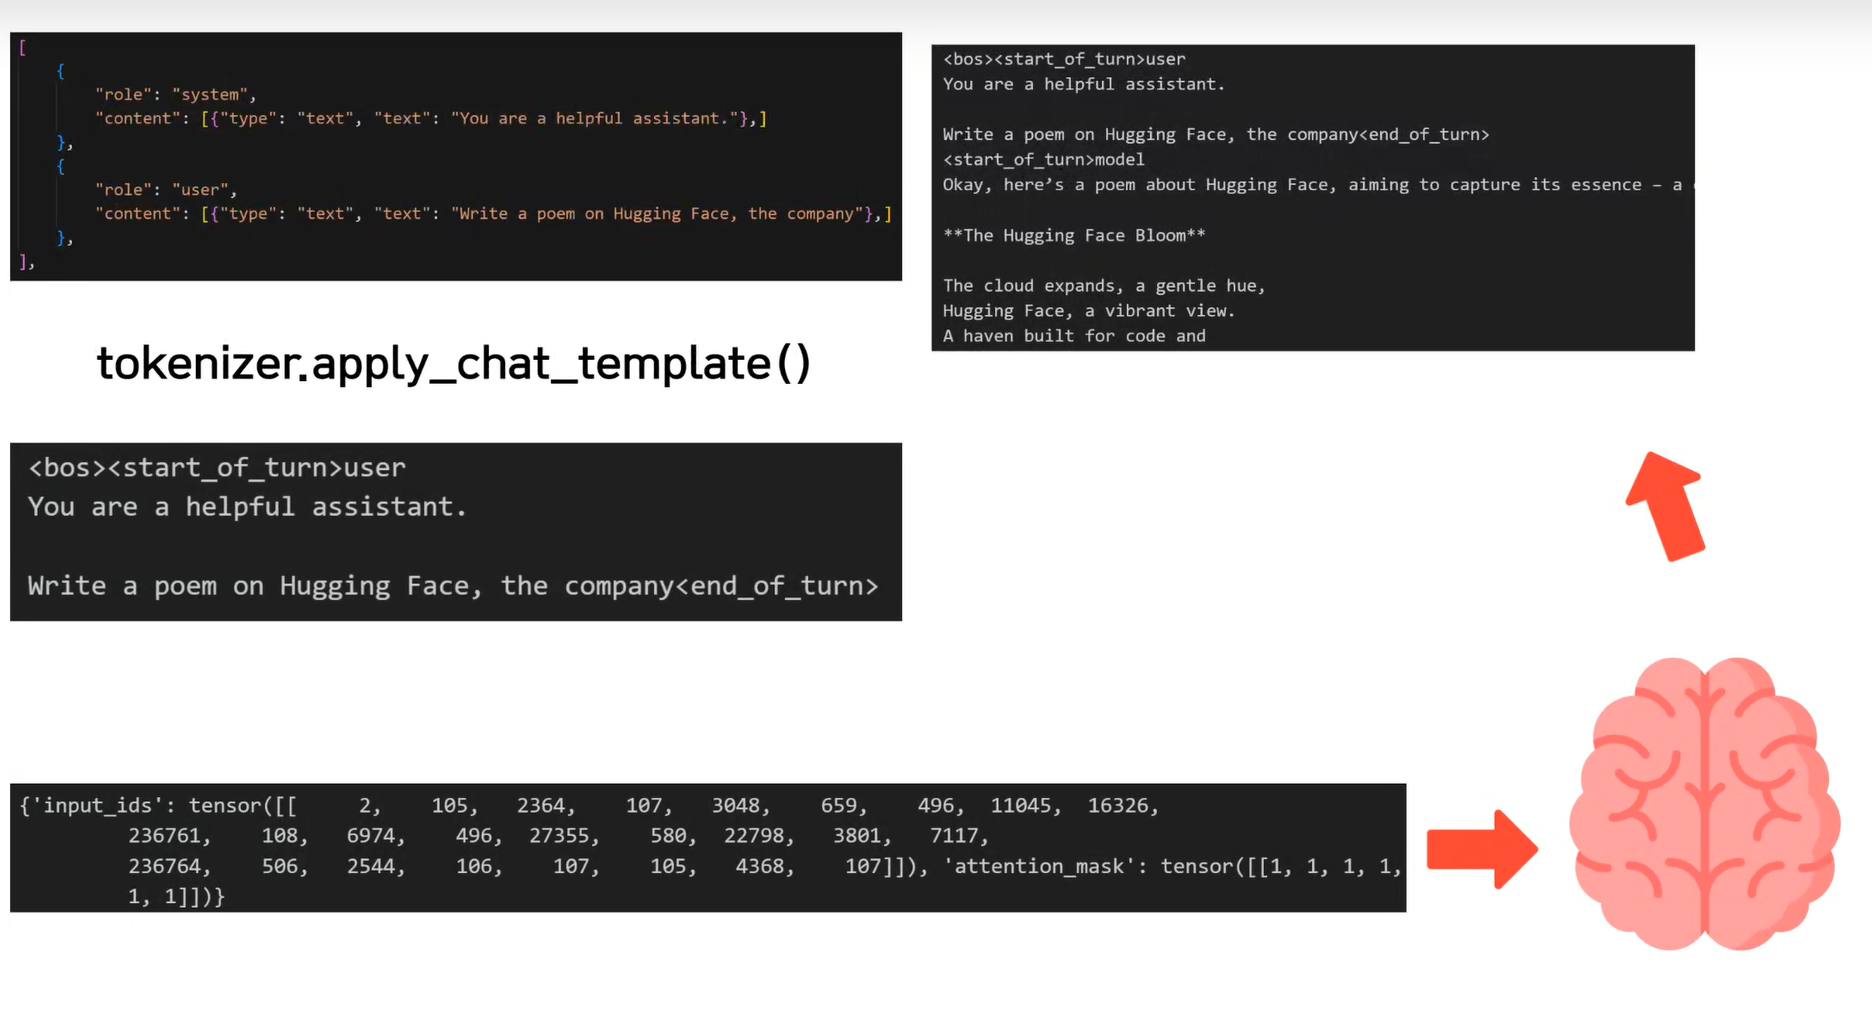

### 정리1. messages변수가 토크나이저를 만나 숫자로 바뀌는 과정
#### 1) messages를 토크나이저를 통해 숫자로 바꿔야 한다!
##### How?? tokenizer.apply_chat_template(message)
##### 2) tokenizer.apply_chat_template이라는 함수를 이용, tokenize=False ---- messages가 문자로 바뀐 상태가 나온다.
##### 3) tokenize=True로 설정하게 되면, input_ids, attention_mask 딕셔너리로 출력된다.
##### 4) input_ids : 문자 -> 숫자 , attention_mask: 그 자리가 의미가 있는 자리인지 의미가 없는 자리인지를 알려줌
##### 5) 이제 inputs가 준비되었다 -- GPU에 옮긴다 to(device) -- model.generate()

### 정리2. 우리가 예측을 하기 위해서는 어떤 데이터가 준비되어야 할까?
##### inputs = {"input_ids": "A", "attention_mask": "B"}

### 정리3. output은 어떻게 나오는가?

##### tensor([[     2, 236788,  80880,  18515,    563,   5628,    528,    506,   3710,
#####             529,   9079, 236764,   7001, 236761, 255999,    818,  94648,  25822,
#####             563,    496, 236743, 236800, 236778, 236812, 236772,  33307, 236772,
#####           11480,  18515,    528,   9079, 236764,   7001, 236761, 255999,    818,
#####           94648,  25822,    563,    496,   5404,    529,   9079,    532,   7001,
#####          236761, 255999,    818,  94648,  25822,    563,    496,   5404,    529,
#####            9079,    532,   7001]], device='cuda:0')

### 정리4. output에서 답변은 어떻게 추출할 수 있을까?
##### decode를 통해서 숫자 텐서를 텍스트로 바꿔야 한다. 
##### tensor([데이터1, 데이터2, ...]) 인 경우, tokenizer.batch_decode
##### tensor(데이터1)인 경우, tokenizer.decode

### https://huggingface.co/google/gemma-3-1b-pt : PT

### https://huggingface.co/google/gemma-3-1b-it : PT + 말투나 방식

## IT

In [ ]:
model_id = "google/gemma-3-1b-it"

# Step1. 모델/토크나이저 불러오기
# 양자화된 모델 로드(무조건 좋은 것은 아님 - 간단한 추론엔 유리할 수 있음(데이터 소실 가능성 있음))
quantization_config = BitsAndBytesConfig(load_in_8bit=True) 

model = Gemma3ForCausalLM.from_pretrained(
    model_id, 
    quantization_config=quantization_config # 양자화 하면 device(cuda)로 보내짐 
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Step2. input setting
messages = [
    [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant."},]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": "Write a poem on Hugging Face, the company"},]
        },
    ],
]

# Step3. input 토크나이징(시스템이 이해 할 수 있는 형태로 변환)
# 모든 토큰의 길이가 같아야함
# input_ids(실제 들어가는 메시지) / attention_mask(빈공간을 메꾸는 값들)
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True, # input뒤에 assistant 붙일지 결정
    tokenize=True, # 결과를 토큰화할지 결정
    return_dict=True, # 결과를 딕셔너리로 반환할지 결정
    return_tensors="pt", # 결과를 파이토치로 반환할지 결정
)

print(inputs)

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.


<inputs>
{'input_ids': tensor([[     2,    105,   2364,    107,   3048,    659,    496,  11045,  16326,
         236761,    108,   6974,    496,  27355,    580,  22798,   3801,   7117,
         236764,    506,   2544,    106,    107,    105,   4368,    107]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}


In [8]:
inputs1 = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=False, # input뒤에다가 assistant를 붙일지 결정
    tokenize=False,              # 결과를 토큰화할지 여부
)
print(inputs1)

['<bos><start_of_turn>user\nYou are a helpful assistant.\n\nWrite a poem on Hugging Face, the company<end_of_turn>\n']


In [17]:
inputs2 = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True, # input뒤에다가 assistant를 붙일지 결정
    tokenize=True,              # 결과를 토큰화할지 여부
)
print(inputs2)

[[2, 105, 2364, 107, 3048, 659, 496, 11045, 16326, 236761, 108, 6974, 496, 27355, 580, 22798, 3801, 7117, 236764, 506, 2544, 106, 107, 105, 4368, 107]]


In [ ]:
# STEP4. 추론하기
inputs = inputs.to(device)

with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=64)

outputs = tokenizer.batch_decode(outputs)
print(outputs)

['<bos><start_of_turn>user\nYou are a helpful assistant.\n\nWrite a poem on Hugging Face, the company<end_of_turn>\n<start_of_turn>model\nOkay, here’s a poem about Hugging Face, aiming for a helpful and appreciative tone:\n\n---\n\nWithin the realm of code and bright design,\nHugging Face, a place truly divine.\nA hub of models, diverse and bold,\nA community where knowledge is untold.\n\nFrom transformers to']


In [13]:
print(outputs[0])

<bos><start_of_turn>user
You are a helpful assistant.

Write a poem on Hugging Face, the company<end_of_turn>
<start_of_turn>model
Okay, here’s a poem about Hugging Face, aiming for a helpful and appreciative tone:

---

Within the realm of code and bright design,
Hugging Face, a place truly divine.
A hub of models, diverse and bold,
A community where knowledge is untold.

From transformers to


In [16]:
input_len = inputs['input_ids'].shape[1]
print(outputs[0][input_len:])

ou are a helpful assistant.

Write a poem on Hugging Face, the company<end_of_turn>
<start_of_turn>model
Okay, here’s a poem about Hugging Face, aiming for a helpful and appreciative tone:

---

Within the realm of code and bright design,
Hugging Face, a place truly divine.
A hub of models, diverse and bold,
A community where knowledge is untold.

From transformers to


## PT

In [ ]:
model_id = "google/gemma-3-1b-pt"

# 양자화도 가능함
# Step1. 모델/토크나이저 불러오기
model = Gemma3ForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Step2. input setting
prompt = "Eiffel tower is located in"

# Step3. input 토크나이징(단순 text input은 apply_chat_template 필요 없음)
inputs = tokenizer(
    prompt, 
    return_tensors="pt"
).to(model.device)

print(inputs)

input_len = inputs["input_ids"].shape[-1]

# Step4. 추론하기
with torch.inference_mode():
    outputs = model.generate(
        **inputs, 
        max_new_tokens=50, 
        do_sample=False
    )
    
print(outputs.shape)
print(outputs[0])
    
outputs_s = tokenizer.decode(outputs[0])
print(outputs_s)

outputs_b = tokenizer.batch_decode(outputs) # 복수개 응답
print(outputs_b)

{'input_ids': tensor([[     2, 236788,  80880,  18515,    563,   5628,    528]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
torch.Size([1, 57])
tensor([     2, 236788,  80880,  18515,    563,   5628,    528,    506,   3710,
           529,   9079, 236764,   7001, 236761, 255999,    818,  94648,  25822,
           563,    496, 236743, 236800, 236778, 236812, 236772,  33307, 236772,
         11480,  18515,    528,   9079, 236764,   7001, 236761, 255999,    818,
         94648,  25822,    563,    496,   5404,    529,   9079,    532,   7001,
        236761, 255999,    818,  94648,  25822,    563,    496,   5404,    529,
          9079,    532,   7001], device='cuda:0')
<bos>Eiffel tower is located in the heart of Paris, France.<start_of_image>The Eiffel Tower is a 324-meter-high tower in Paris, France.<start_of_image>The Eiffel Tower is a symbol of Paris and France.<start_of_image>The Eiffel Tower is a symbol of Paris and France
['<bos>Eiff

# 정리
# 1. 우리가 허깅페이스에서 LLM 모델을 사용하려고 할 때, 모델은 어떻게 불러오나요?
## 모델 이름이 있는 사이트에 들어가면 
## pipeline 함수로도 추론할 수 있고,
## model을 직접 불러와서 할 수도 있다. -----⭐ 파인튜닝: 내 데이터를 이미 학습되어 있는 모델에 적용시키기 위해 model
# 2. instruct 모델이 있고, 그냥 pre-trained 모델이 있는데 모델에 input해야 할 데이터는 어떻게 생겼나요?
## LLM 학습 방법 
## 1) Pre-trained model에서 "새로운 정보"를 학습시킨다. ex. gemma-3-1b-pt INPUT: "프롬프트를 작성해주세요" (str)
## 2) Instruct model에서 "말하는 방식"을 학습시킨다. ex. gemma-3-1b-it INPUT: 대화 [{"role": , "content": }] * 지시사항까지 학습한다.
# 3. input 해야할 데이터는 어떻게 만드나요?
## 텍스트 -- 텐서 -- model -- 텐서 -- 텍스트 
##     tokenizer             tokenizer
##     tokenize()            tokenizer.decode()
##    tokenize.apply_chat_template()

In [ ]:
print(tokenizer.bos_token_id) # End of Sequence
print(tokenizer.eos_token_id) # Beginning of Sequence

1
2


In [26]:
# 응용해보기
prompt = [
    "남산타워는 어디에 있나요?<eos>",
    "경복궁은 어디에 있나요?<eos>"
]
prompt = "남산타워는 어디에 있나요?\n경복궁은 어디에 있나요?"

# STEP3. 입력 데이터 토크나이징하기
inputs = tokenizer(
    "".join(prompt), 
    # return_tensors="pt"
)
print(inputs)
inputs = inputs.to(device) # GPU 보내기

{'input_ids': [2, 239120, 238500, 238503, 239592, 237170, 110388, 237223, 5386, 103595, 236881, 107, 238136, 239484, 241845, 237456, 110388, 237223, 5386, 103595, 236881], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [6]:
import transformers

model_id = "MLP-KTLim/llama-3-Korean-Bllossom-8B"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

pipeline.model.eval()

PROMPT = '''You are a helpful AI assistant. Please answer the user's questions kindly. 당신은 유능한 AI 어시스턴트 입니다. 사용자의 질문에 대해 친절하게 답변해주세요.'''
instruction = "서울의 유명한 관광 코스를 만들어줄래?"

messages = [
    {"role": "system", "content": f"{PROMPT}"},
    {"role": "user", "content": f"{instruction}"}
    ]

prompt = pipeline.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = pipeline(
    prompt,
    max_new_tokens=2048,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)

print(outputs[0]["generated_text"][len(prompt):])


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

c:\walker\code\llm\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--MLP-KTLim--llama-3-Korean-Bllossom-8B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some parameters are on the meta device because they were offloaded to the cpu.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

Device set to use cuda:0


서울은 다양한 문화, 역사, 그리고 현대적인 매력을 동시에 지니고 있는 도시입니다. 여기 서울의 유명한 관광 코스를 제안해 드리겠습니다. 이 코스는 서울의 주요 명소를 효율적으로 방문할 수 있도록 구성했습니다.

### 코스 1: 역사와 문화의 중심지

1. **경복궁**
   - 서울의 대표적인 조선시대의 궁궐로, 다양한 건축물과 정원이 있습니다.
   
2. **창덕궁**
   - 경복궁과 함께 조선시대의 대표적인 궁궐로, 경회루와 인화문이 유명합니다.
   
3. **북촌 한옥마을**
   - 전통 한옥이 잘 보존된 마을로, 조선시대의 전통 주거지를 체험할 수 있습니다.
   
4. **인사동**
   - 전통 문화와 현대 예술이 어우러진 거리로, 다양한 갤러리와 전통 찻집이 있습니다.

### 코스 2: 현대의 서울

1. **명동**
   - 쇼핑과 식사를 즐길 수 있는 대표적인 거리로, 다양한 브랜드 매장과 레스토랑이 있습니다.
   
2. **홍대**
   - 젊은 세대의 문화와 예술을 느낄 수 있는 지역으로, 다양한 카페와 갤러리, 클럽이 있습니다.
   
3. **인사동**
   - 전통과 현대가 어우러진 거리로, 전통 찻집과 현대적인 갤러리, 카페가 있습니다.
   
4. **남산 서울타워**
   - 서울의 전경을 한눈에 볼 수 있는 곳으로, 야경이 아름다워 합니다.

### 코스 3: 자연과 휴식

1. **남산 서울타워**
   - 서울의 전경을 한눈에 볼 수 있는 곳으로, 야경이 아름다워 합니다.
   
2. **한강공원**
   - 서울의 주요 공원 중 하나로, 수영, 자전거 타기, 산책 등 다양한 활동을 즐길 수 있습니다.
   
3. **북촌 한옥마을**
   - 전통 한옥이 잘 보존된 마을로, 조선시대의 전통 주거지를 체험할 수 있습니다.
   
4. **경복궁공원**
   - 경복궁과 인접해 있으며, 조선시대의 정원과 건축물을 볼 수 있습니다.

이 코스를 통해 서울의 다양한 면모를 체험할 수 있을 것입니다. 각 코스를 선택하